In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import sys
sys.path.append('./')

# from intersections_and_roads import *
from final_project import *
# from search import *
from shapely.geometry import *
import ast

**Cambridge Graph**

In [2]:
cambridge_map = map_structure(city='Cambridge')

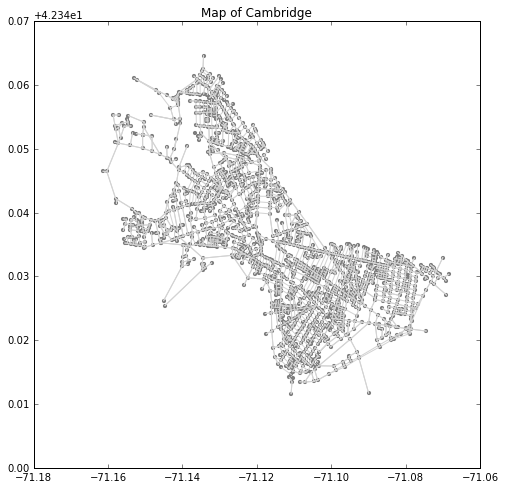

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph(ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

**San Francisco**

In [4]:
san_fran_map = map_structure(city='San Francisco')

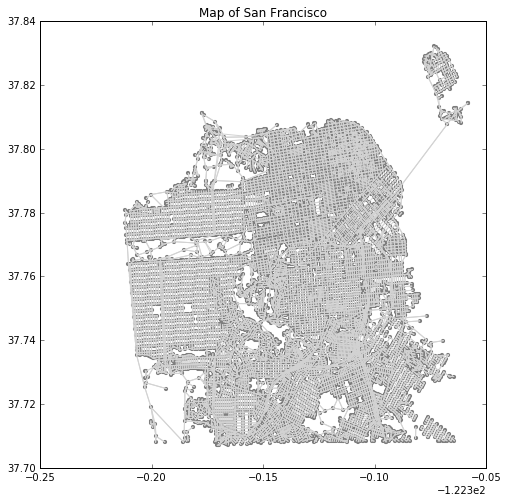

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph(ax=ax)
ax.set_title('Map of San Francisco')
plt.show()

### Section 1: Graph Search - A*

In [6]:
# randomly select a start and an end point on the graph for test
intersection_graph = san_fran_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [7]:
# search the graph
route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_road_cost,
                                   heuristic=san_fran_map.null_heuristic)
safe_route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_safe_road_cost,
                                   heuristic=san_fran_map.null_heuristic)

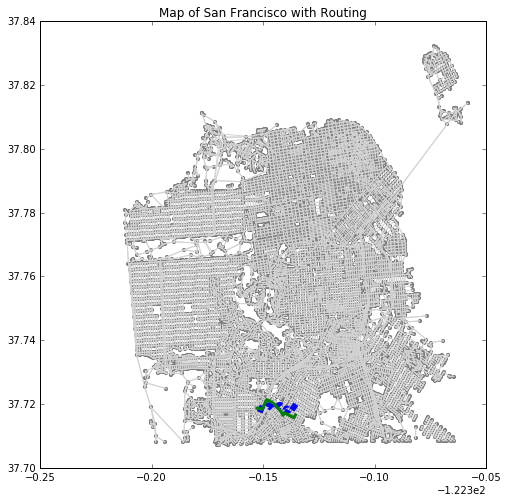

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph([route['nodes']], [safe_route['nodes']], ax=ax)
ax.set_title('Map of San Francisco with Routing')
plt.show()

**Lets collect some data:**

In [9]:
def sim(start, end, cost_fn, heuristic_fn):
    route, nodes_expanded = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=cost_fn,
                                   heuristic=heuristic_fn,
                                   return_expanded_nodes = True)
    
    solution_distance = san_fran_map.get_road_cost(route['nodes'], route['connections'])
    delta_elev = np.sum([san_fran_map.road_connections[conn].delta_elevation for conn in route['connections']])
    return (route['nodes'], solution_distance, delta_elev, len(nodes_expanded))

def execute_simulation(nsims, cost_fn):
    euclidean_dist = []
    solution_nodes = [[],[],[]]
    solution_route_distance = [[],[],[]]
    solution_delta_elevation = [[],[],[]]
    solution_nodes_expanded = [[],[],[]]

    for i in range(nsims):
        start = intersection_graph[np.random.choice(intersection_graph.keys())]
        end = intersection_graph[np.random.choice(intersection_graph.keys())]
        while end.id == start.id:
            end = intersection_graph[np.random.choice(intersection_graph.keys())]
        
        euclid_dist = euclidean_distance(start.get_x_y(), end.get_x_y())

        euclidean_dist.append(euclid_dist)
        # under the null heuristic
        k = 0
        result = sim(start, end, cost_fn, san_fran_map.null_heuristic)
        solution_nodes[k].append(result[0])
        solution_route_distance[k].append(result[1])
        solution_delta_elevation[k].append(result[2])
        solution_nodes_expanded[k].append(result[3])

        # under the euclidean_heuristic heuristic
        k = 1
        result = sim(start, end, cost_fn, san_fran_map.euclidean_heuristic)
        solution_nodes[k].append(result[0])
        solution_route_distance[k].append(result[1])
        solution_delta_elevation[k].append(result[2])
        solution_nodes_expanded[k].append(result[3])

        k = 2
        # under the combined_heuristic heuristic
        result = sim(start, end, cost_fn, san_fran_map.combined_heuristic)
        solution_nodes[k].append(result[0])
        solution_route_distance[k].append(result[1])
        solution_delta_elevation[k].append(result[2])
        solution_nodes_expanded[k].append(result[3])
        
    return euclidean_dist, solution_nodes, solution_route_distance, solution_delta_elevation, solution_nodes_expanded

Basic road cost

In [10]:
# Cost function = get_road_cost ## I.e. simple road cost
(euclidean_dist, solution_nodes, solution_route_distance,
         solution_delta_elevation, solution_nodes_expanded) = execute_simulation(20, san_fran_map.get_road_cost)

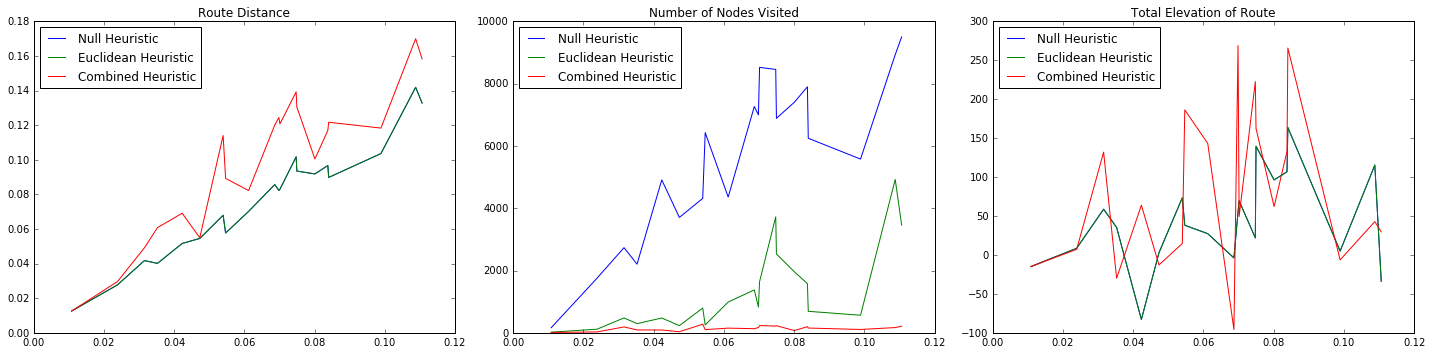

In [11]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost

In [12]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
(euclidean_dist, solution_nodes, solution_route_distance,
         solution_delta_elevation, solution_nodes_expanded) = execute_simulation(20, san_fran_map.get_safe_road_cost)

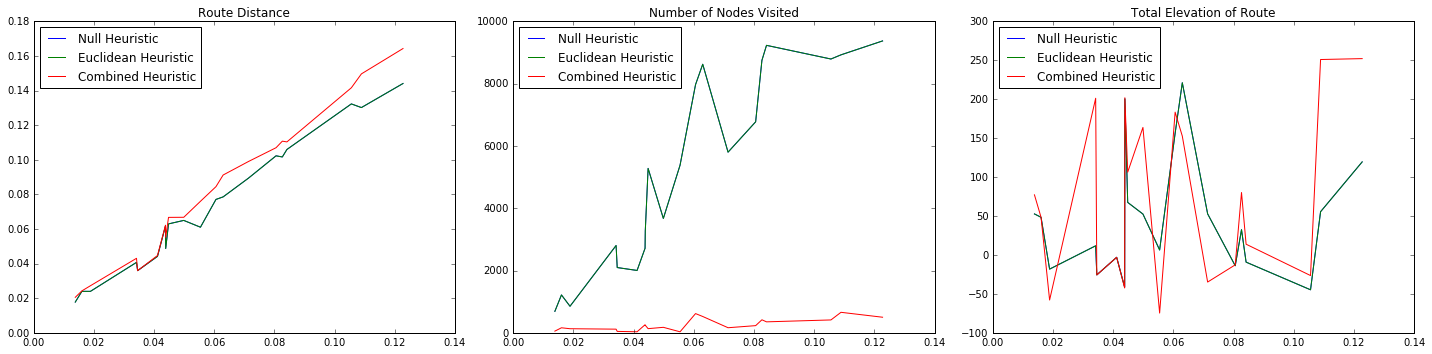

In [13]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost with Elevation

In [17]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
(euclidean_dist, solution_nodes, solution_route_distance,
         solution_delta_elevation, solution_nodes_expanded) = execute_simulation(10, san_fran_map.get_safe_road_cost_with_elevation)

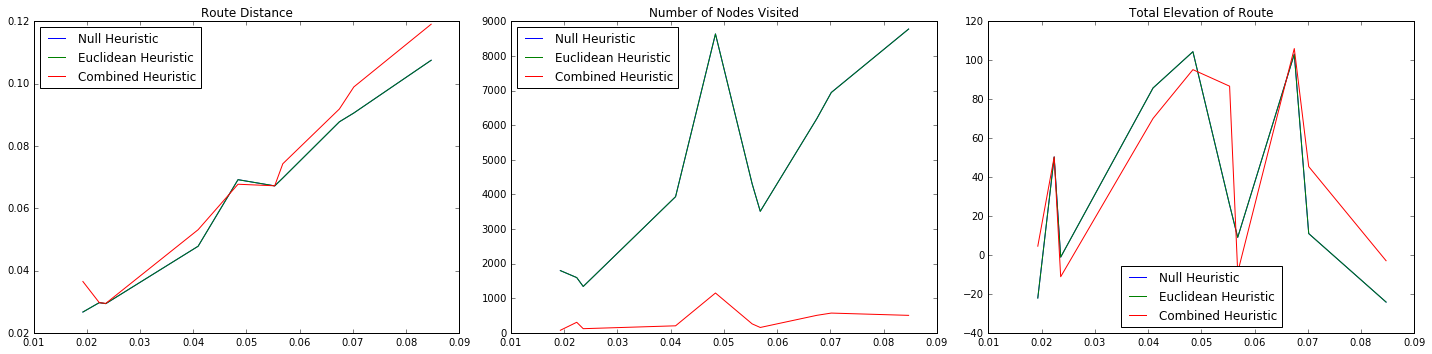

In [18]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Local Search: Simulated Annealing, K-Beam